# Specific Other thigns to Test

1. Viz discounts in train

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DIRECTORY = './data/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date'])
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date'])
solution = pd.read_csv(DIRECTORY + 'solution.csv')
test_weights = pd.read_csv(DIRECTORY + 'test_weights.csv')

In [3]:
discount_cols = [col for col in train.columns if 'discount' in col]
train[discount_cols].describe()

,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
count,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06
mean,8.518626e-03,1.240899e-04,1.163193e-03,5.452819e-06,5.680178e-03,4.049705e-04,1.045480e-02
std,5.147027e-02,5.142815e-03,1.879977e-02,8.922436e-04,2.892965e-02,9.199913e-03,5.545035e-02
min,-2.094930e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.712000e-02,0.000000e+00,-8.014900e-01
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.916400e-01,5.000000e-01,7.637200e-01,2.506300e-01,4.529000e-01,6.691400e-01,9.000500e-01


2. How do different factors affect sales (sell price, availability, discounts)

In [4]:
inventory['name_first'] = inventory['name'].str.split('_').str[0]
train = train.sort_values(by='date')
train = train.merge(inventory, on='unique_id', how='left')

In [5]:
train[train['name_first'] == 'Blueberry']['product_unique_id'].unique()

array([1614, 2602,  918, 2470,  799, 1232,  699,   16,  818, 1506,  283,
       1635, 1609, 1340,  940, 1282, 1866,  782,  547,  850,  630, 1807,
       1720,    1, 1589, 2181,  890, 2166,  489, 1263, 2332, 2007, 1881,
          9, 1109, 2257])

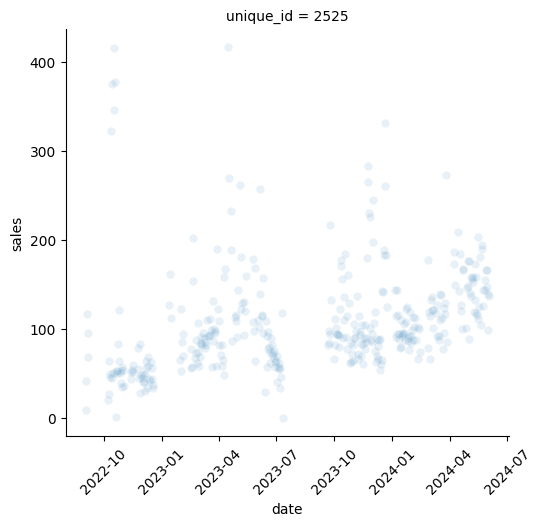

In [6]:
g = sns.relplot(
    data=train[train['product_unique_id'] == 1263], 
    x='date', 
    y='sales', 
    alpha=0.1, 
    col='unique_id', 
    col_wrap=3
)

# Rotate x-axis tick labels
for ax in g.axes.flat:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.show()

In [8]:
sns.relplot(train[train['name_first'] == 'Blueberry'], x='date', y='sales', alpha=0.1, col='unique_id', col_wrap=3)
plt.show()

KeyboardInterrupt: 

In [9]:
inventory[inventory['unique_id'] == 1]

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse,name_first
3849,1,1,Blueberry_0,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_1,Fruit and vegetable_L4_1,Frankfurt_1,Blueberry


3. How many "gaps" does the average product have?

How many consecutive ranges do they have with rows

In [10]:
# How many unique ids are fully contiguous
day_range = (train.groupby('unique_id')['date'].max() - train.groupby('unique_id')['date'].min()).dt.days
day_count = train.groupby('unique_id')['date'].count()

(day_range == day_count).value_counts()

date
False    5274
True      116
Name: count, dtype: int64

In [11]:
# How may times is the previous day not the day before

train['prev_sale_day'] = train.groupby('unique_id')['date'].shift(1)

In [12]:
train['is_noncontinuous'] = train['date'] > (train['prev_sale_day'] + pd.Timedelta('7D'))

In [13]:
count_noncontinuous = train.groupby('unique_id')['is_noncontinuous'].sum()
count_noncontinuous.describe()

count    5390.000000
mean        1.757328
std         2.674755
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        43.000000
Name: is_noncontinuous, dtype: float64

<Figure size 640x480 with 0 Axes>

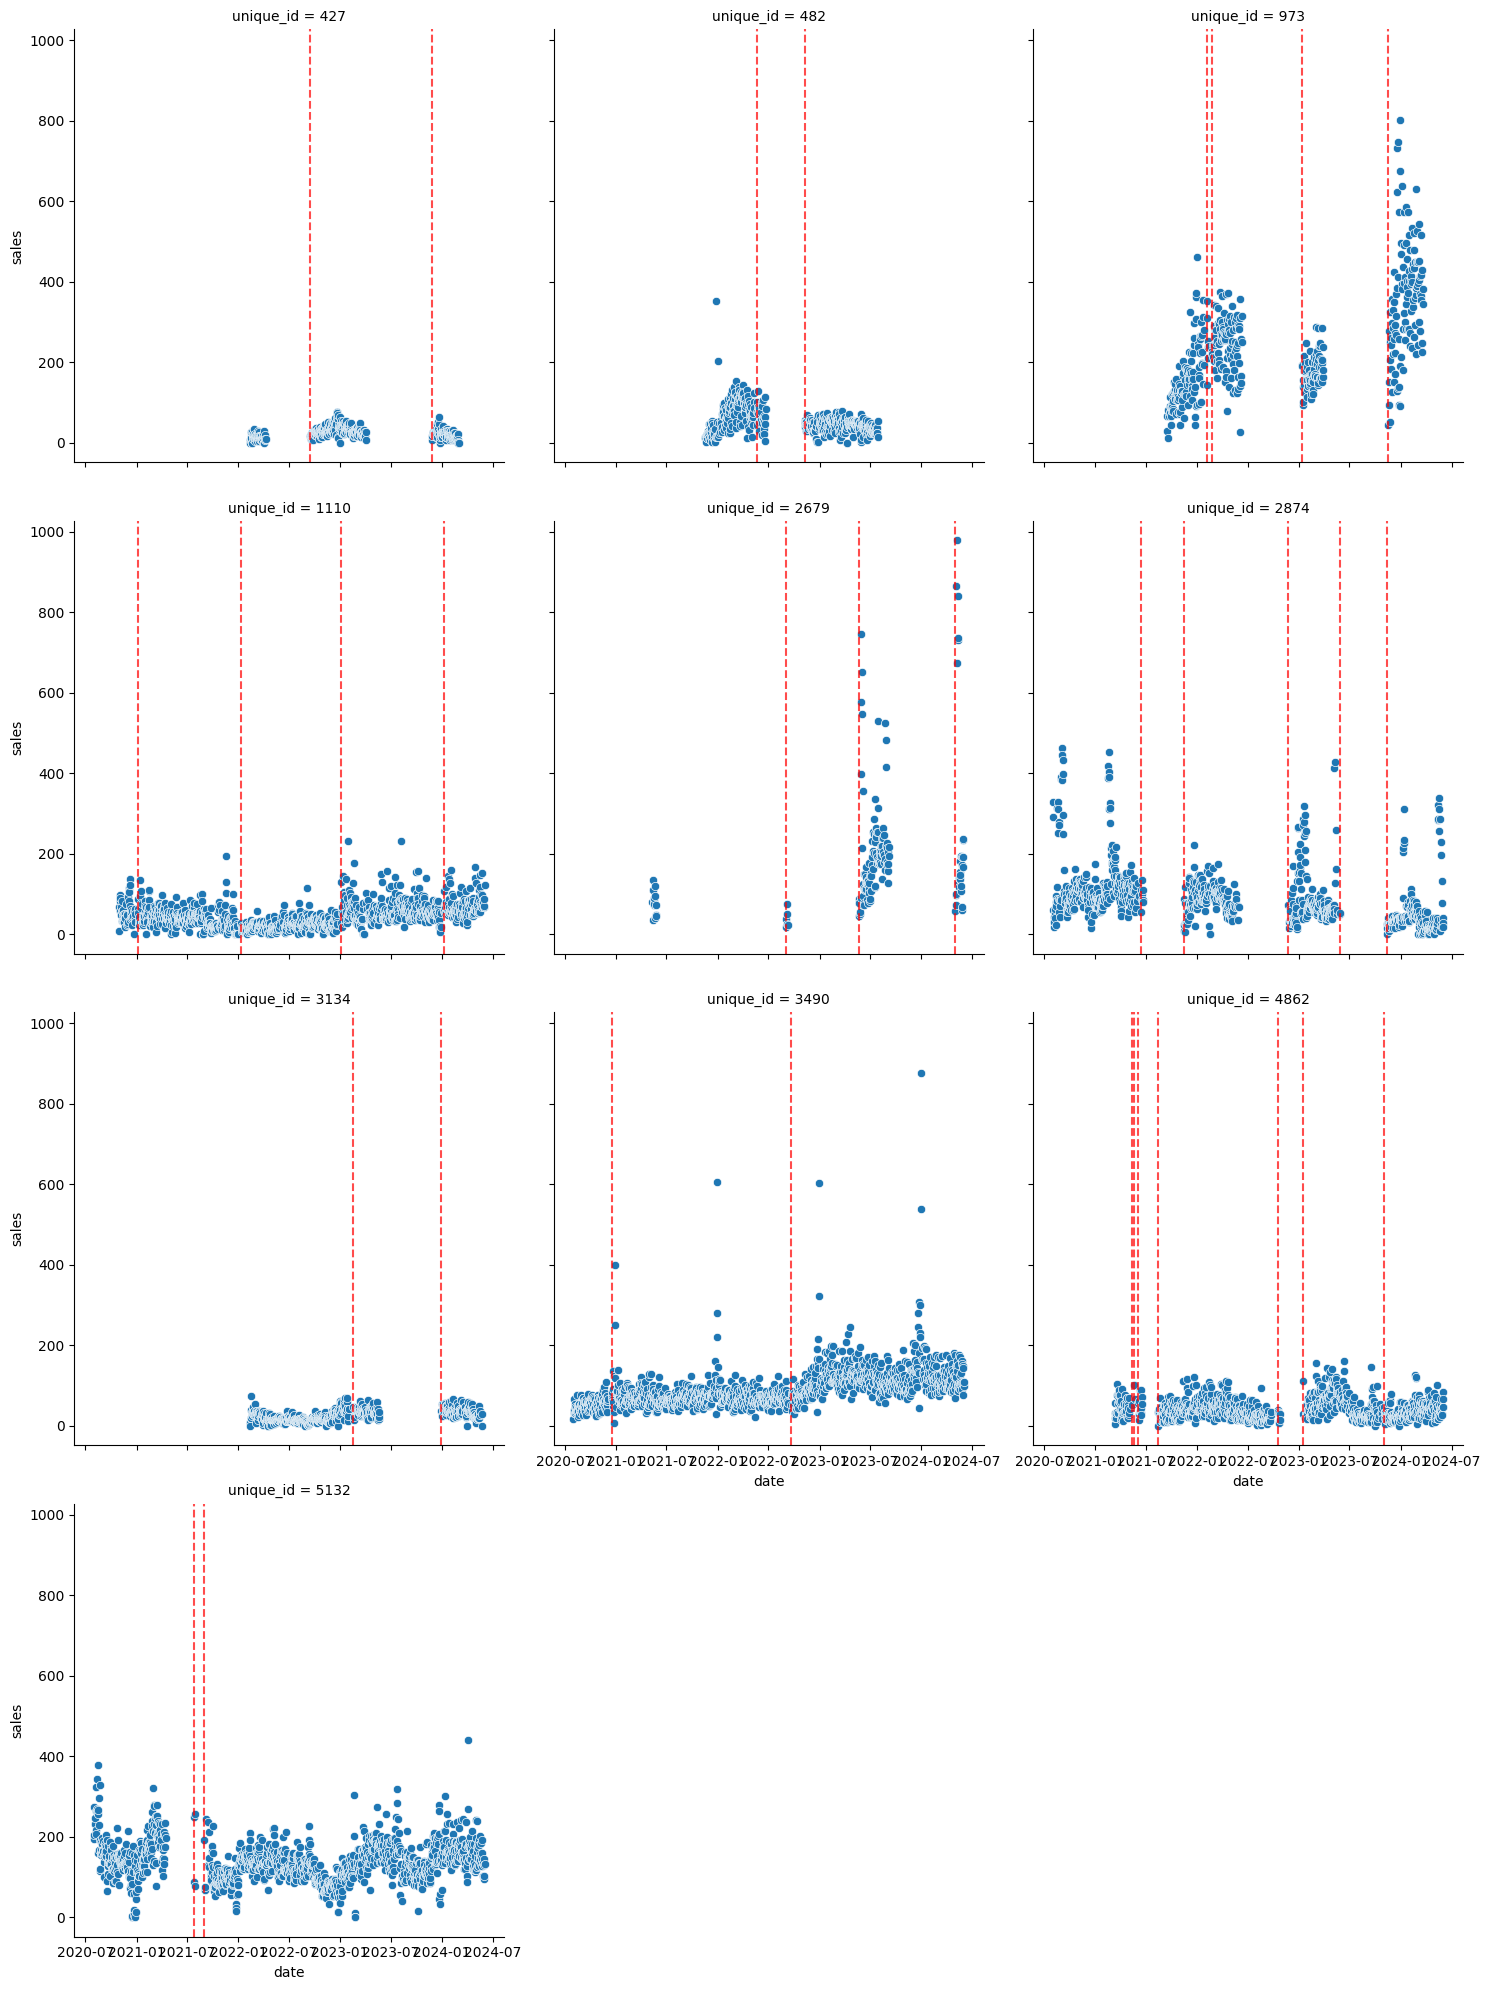

In [14]:
chosen = count_noncontinuous[count_noncontinuous > 1].sample(10).index
chosen_train = train[train['unique_id'].isin(chosen)]
chosen = chosen_train['unique_id'].unique()

plt.clf()
g = sns.relplot(chosen_train, x='date', y='sales', col='unique_id', col_wrap=3, kind='scatter')
# Loop through each subplot and add vertical lines where 'indicator' is True
for unique_id, ax in g.axes_dict.items():
    subset = train[(train['unique_id'] == unique_id) & (train['is_noncontinuous'] == True)]
    
    for date in subset['date']:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.7)

plt.show();

# Viz Test
Look at random items IN TEST

In [26]:
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date'])
test.groupby('unique_id')['date'].count().value_counts()

date
14    2688
13     278
12     174
11      94
10      77
9       53
8       50
5       45
7       43
6       40
4       33
3       23
1       15
2       12
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

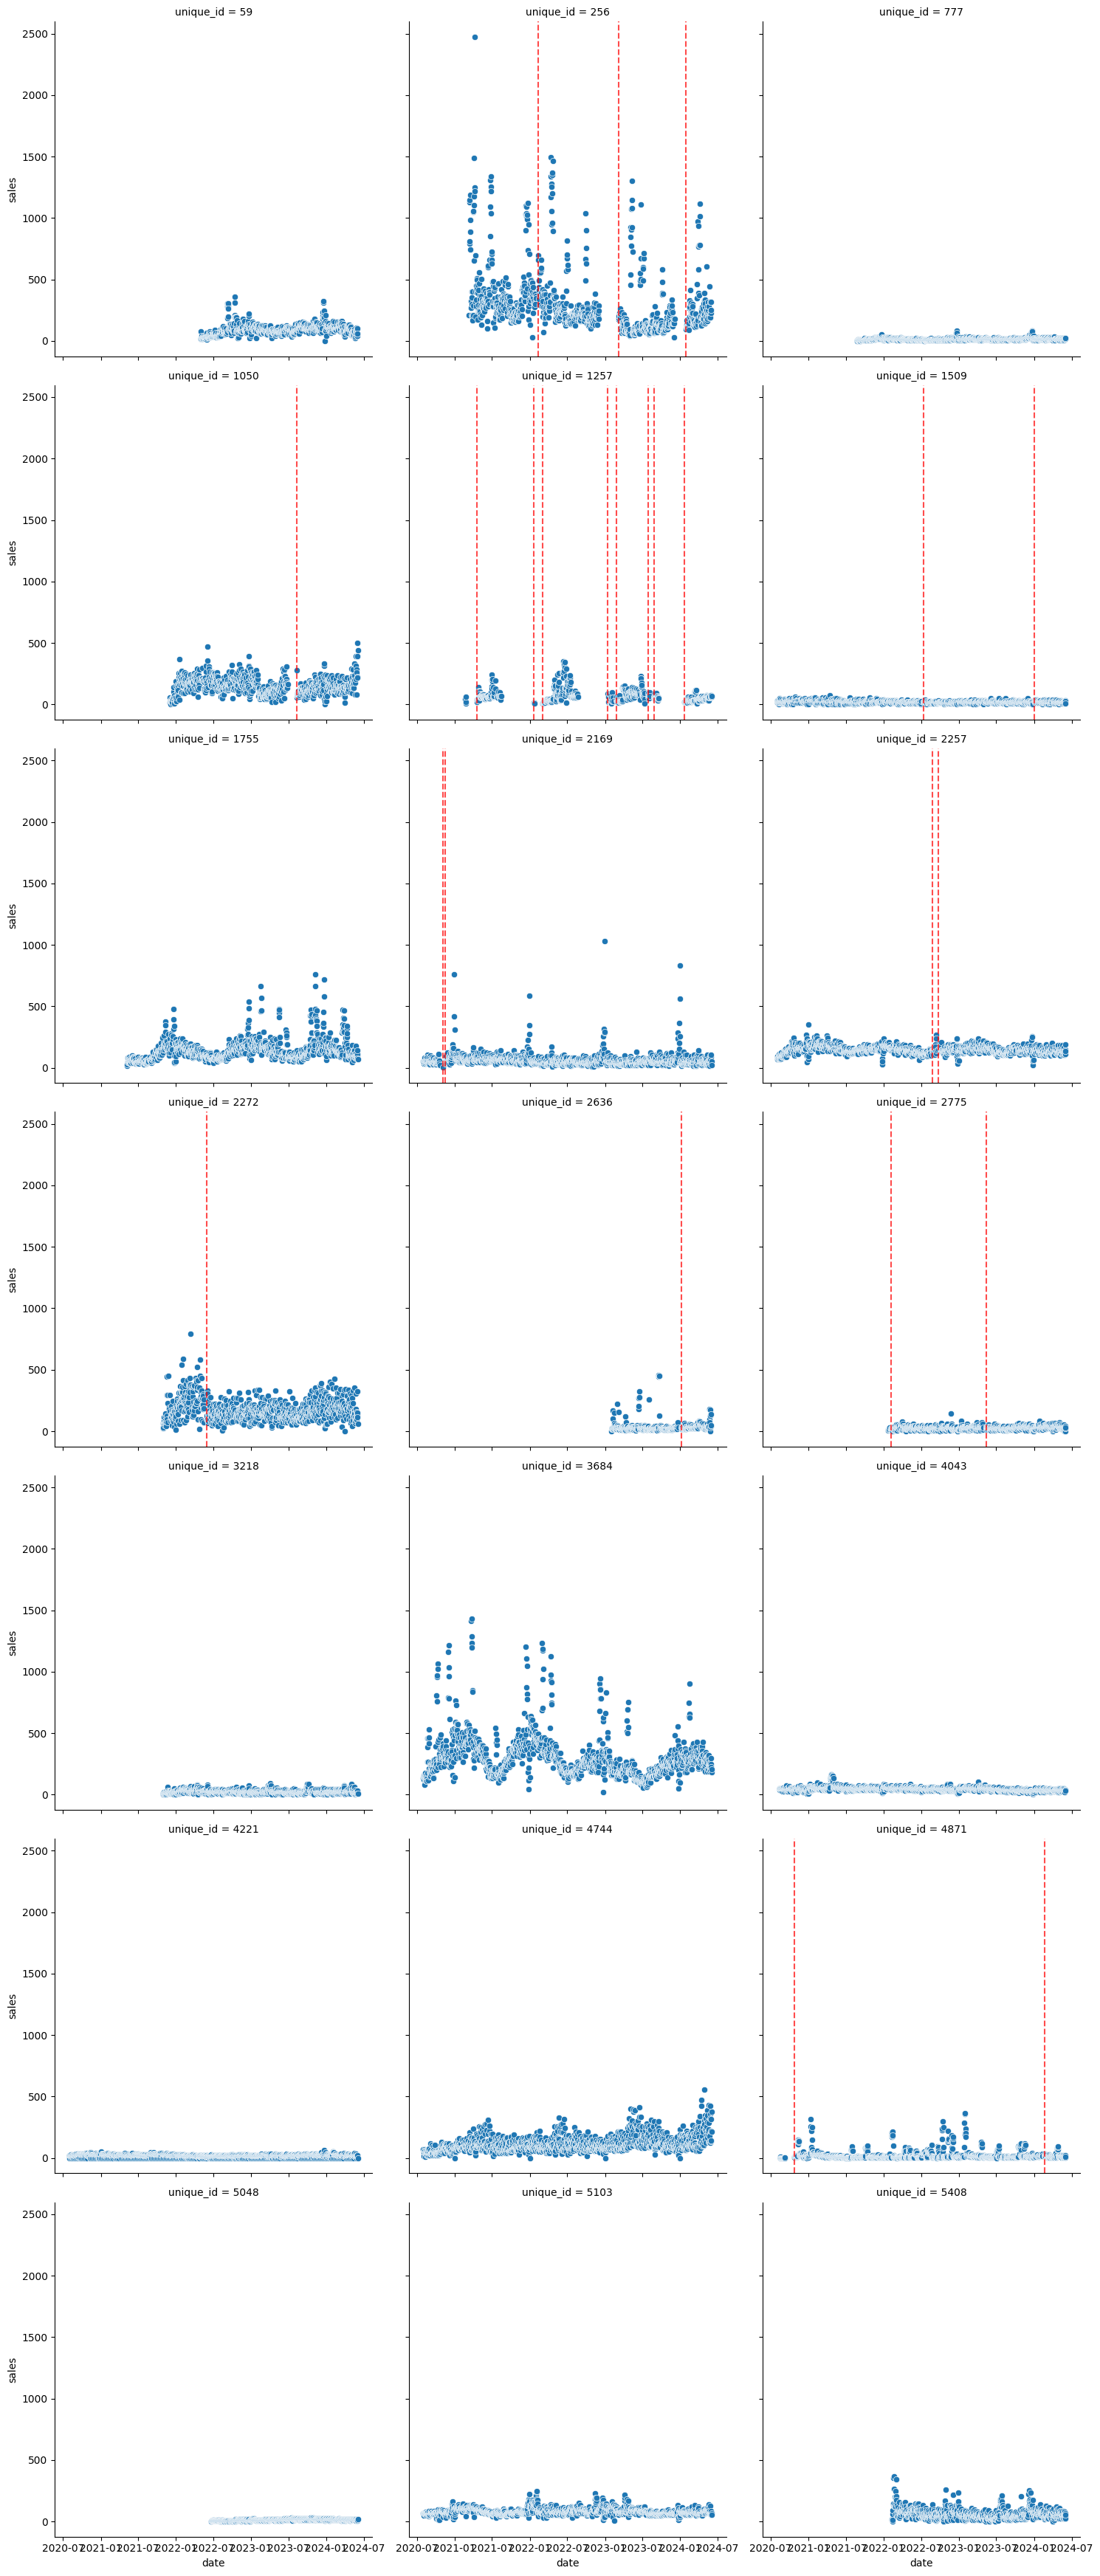

In [28]:
chosen = test['unique_id'].sample(21)
chosen_train = train[train['unique_id'].isin(chosen)]
chosen = chosen_train['unique_id'].unique()

plt.clf()
g = sns.relplot(chosen_train, x='date', y='sales', col='unique_id', col_wrap=3, kind='scatter')
# Loop through each subplot and add vertical lines where 'indicator' is True
for unique_id, ax in g.axes_dict.items():
    subset = train[(train['unique_id'] == unique_id) & (train['is_noncontinuous'] == True)]
    
    for date in subset['date']:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.7)

plt.show();

In [31]:
# Look at ones that look "almost continuous"
# Why do they have gaps?

relevant_ids = [1509, 2636, 2775]
curr_id = relevant_ids[0]

curr_id_df = train[train['unique_id'] == curr_id].sort_values(by='date')
contained_dates = curr_id_df['date'].unique()
full_range = pd.date_range(curr_id_df['date'].min(), curr_id_df['date'].max())

<Axes: xlabel='None'>

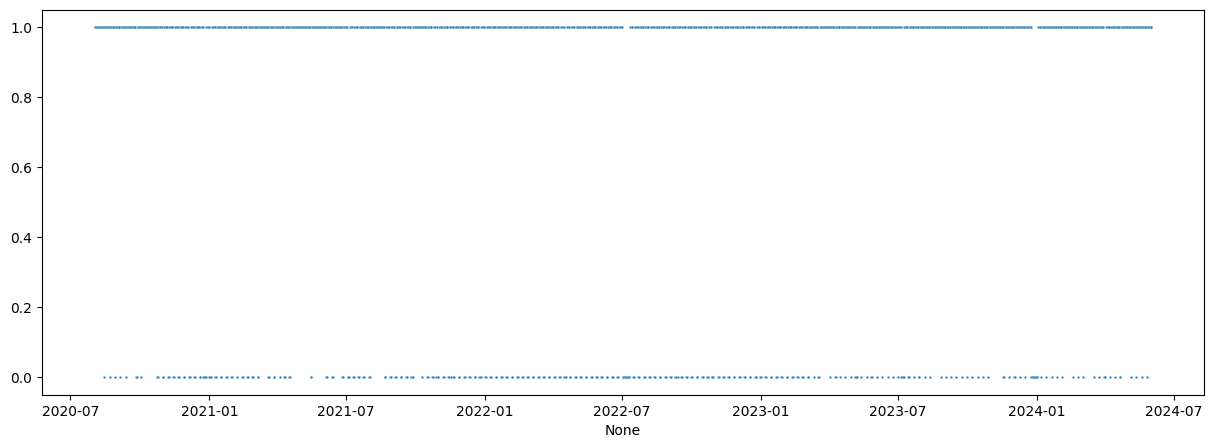

In [45]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=full_range, y=full_range.isin(contained_dates), s=3)

In [46]:
train[train['sales'] == 0]

,unique_id,date,warehouse_x,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse_y,name_first,prev_sale_day,is_noncontinuous
29,5038,2020-08-01,Prague_1,4111.0,0.0,33.67,0.84,0.00000,0.0,0.0,...,2467,Pastry_187,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,Prague_1,Pastry,NaT,False
32,3593,2020-08-01,Prague_1,4111.0,0.0,42.92,1.00,0.00000,0.0,0.0,...,1769,Bread_141,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,Prague_1,Bread,NaT,False
34,4273,2020-08-01,Prague_3,2466.0,0.0,19.21,1.00,0.00000,0.0,0.0,...,2107,Herb_15,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3,Herb,NaT,False
62,2818,2020-08-01,Budapest_1,3395.0,0.0,514.53,1.00,0.00000,0.0,0.0,...,1397,Salad_30,Fruit and vegetable,Fruit and vegetable_L2_6,Fruit and vegetable_L3_9,Fruit and vegetable_L4_60,Budapest_1,Salad,NaT,False
66,5337,2020-08-01,Prague_1,4111.0,0.0,67.01,1.00,0.00000,0.0,0.0,...,2623,Tangerine_0,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_46,Fruit and vegetable_L4_36,Prague_1,Tangerine,NaT,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007155,3779,2024-06-02,Budapest_1,6143.0,0.0,827.17,0.34,0.20275,0.0,0.0,...,1854,Bread_148,Bakery,Bakery_L2_9,Bakery_L3_64,Bakery_L4_1,Budapest_1,Bread,2024-06-01,False
4007174,3941,2024-06-02,Brno_1,8360.0,0.0,76.51,0.38,0.00000,0.0,0.0,...,1936,Bread_158,Bakery,Bakery_L2_9,Bakery_L3_75,Bakery_L4_15,Brno_1,Bread,2024-06-01,False
4007232,2360,2024-06-02,Munich_1,2962.0,0.0,1.14,1.00,0.00000,0.0,0.0,...,1178,Pastry_103,Bakery,Bakery_L2_8,Bakery_L3_74,Bakery_L4_1,Munich_1,Pastry,2024-06-01,False
4007251,2027,2024-06-02,Budapest_1,6143.0,0.0,1842.84,0.34,0.00000,0.0,0.0,...,1025,Bread_83,Bakery,Bakery_L2_18,Bakery_L3_110,Bakery_L4_1,Budapest_1,Bread,2024-06-01,False
